# Machine Learning Determining Device From Pattern
This notebook is designed to investigate the mechanics of determining a device id based on a trained classifier

### Imports

In [2]:
import os
from pyMez import *
from pyMez.Code.Analysis.SParameter import *
from pyMez.Code.DataHandlers.NISTModels import *
from pyMez.Code.DataHandlers.Translations import *
import sys
sys.path.insert(0, '..')
#from Machine_Learning import *
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.svm import SVC

Importing pyMez, this should take roughly 30 seconds
Importing Code.DataHandlers.GeneralModels
It took 2.796 s to import Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.HTMLModels
It took 0.367 s to import Code.DataHandlers.HTMLModels
Importing Code.DataHandlers.NISTModels
It took 6.928 s to import Code.DataHandlers.NISTModels
Importing Code.DataHandlers.TouchstoneModels
It took 0.007 s to import Code.DataHandlers.TouchstoneModels
Importing Code.DataHandlers.XMLModels
It took 0.173 s to import Code.DataHandlers.XMLModels
Importing Code.DataHandlers.ZipModels
It took 0.016 s to import Code.DataHandlers.ZipModels
Importing Code.InstrumentControl.Experiments
It took 1.097 s to import Code.InstrumentControl.Experiments
Importing Code.InstrumentControl.Instruments
It took 0.043 s to import Code.InstrumentControl.Instruments
Importing Code.Utils.Names
It took 0.008 s to import Code.Utils.Names
It took 11.435 s to import all of the active modules


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Classifiers that work
note I had some issues with SVD, Gaussian Bayes and Multinominal Bayes

In [3]:
classifier_dict = {"QDA": QuadraticDiscriminantAnalysis,
                   "Bernoulli Naive Bayes": BernoulliNB,
                   "Decision Tree": DecisionTreeClassifier,
                   "Random Forest": RandomForestClassifier,
                   "Ridge": RidgeClassifier,
                   "SGD": SGDClassifier,
                   "Passive Aggressive": PassiveAggressiveClassifier,
                   "Perceptron": Perceptron}

### Load the database to train to 

In [4]:
two_port=pandas.read_csv(r"C:\Share\Converted_Check_Standard\Combined_Two_Port_Check_Standard.csv")
device_ids=two_port["Device_Id"].unique()

C:\ProgramData\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (10,11,12,16,18,19,20,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Organizing the data by device id
training_metadata_dictionary={}
device_history_dictionary={}
for device_id in device_ids[:]:
    device_history=two_port[two_port["Device_Id"]==device_id]
    device_history_dictionary[device_id]=device_history
    unique_metadata_keys=[]
    for column in device_history.columns:
        if len(device_history[column].unique())==1:
            unique_metadata_keys.append(column)
    training_metadata_dictionary[device_id]={key:device_history[key].unique() for key in unique_metadata_keys}

In [6]:
# This is the bare training list
training_list=[]
target_list=[]
training_columns=["Frequency","magS11","argS11","magS21","argS21","magS22","argS22"]
for index,device_id in enumerate(device_ids[:]):
    device=device_history_dictionary[device_id][training_columns].values.tolist()
    for row_index,row in enumerate(device):
        training_list.append(row)
        target_list.append(index)


In [7]:
# Here we train the classifier, I have found that the Desision Tree works best for this type of task
two_port_classifier=DecisionTreeClassifier()
two_port_classifier.fit(training_list, target_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [40]:
# now a test list with noise
mag_std=.00000001
arg_std=.00000001
test_list=[]
test_target_list=[]
for index,device_id in enumerate(device_ids[:]):
    device=device_history_dictionary[device_id][training_columns].values.tolist()
    for row_index,row in enumerate(device):
        for column_index,column_name in enumerate(training_columns):
            if re.search("mag",column_name):
                device[row_index][column_index]= row[column_index]+np.random.normal(0,mag_std)
            elif re.search("arg",column_name):
                device[row_index][column_index]= row[column_index]+np.random.normal(0,arg_std)
            else:
                pass
    for row_index,row in enumerate(device):
        test_list.append(row)
        test_target_list.append(index)

In [8]:
# Look at the predictions using the training list
predictions=two_port_classifier.predict(training_list)

In [41]:
test_predictions=two_port_classifier.predict(test_list)

In [58]:
def percent_correct(target_list,prediction_list):
    """Calculates the number of correct predictions"""
    number_correct=0
    for index,value in enumerate(target_list):
        if prediction_list[index]==value:
            number_correct+=1
    return 100*float(number_correct)/float(len(target_list))
                                             

In [59]:
percent_correct(target_list,predictions.tolist())

99.99956032553497

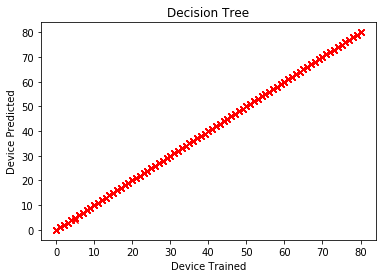

In [24]:
plt.plot(target_list,predictions.tolist(),"rx")
plt.xlabel("Device Trained")
plt.ylabel("Device Predicted")
plt.title("Decision Tree")
plt.show()

In [45]:
number_device_points=[]
for device_index,device_id in enumerate(device_ids):
    number_device_points.append(target_list.count(device_index))


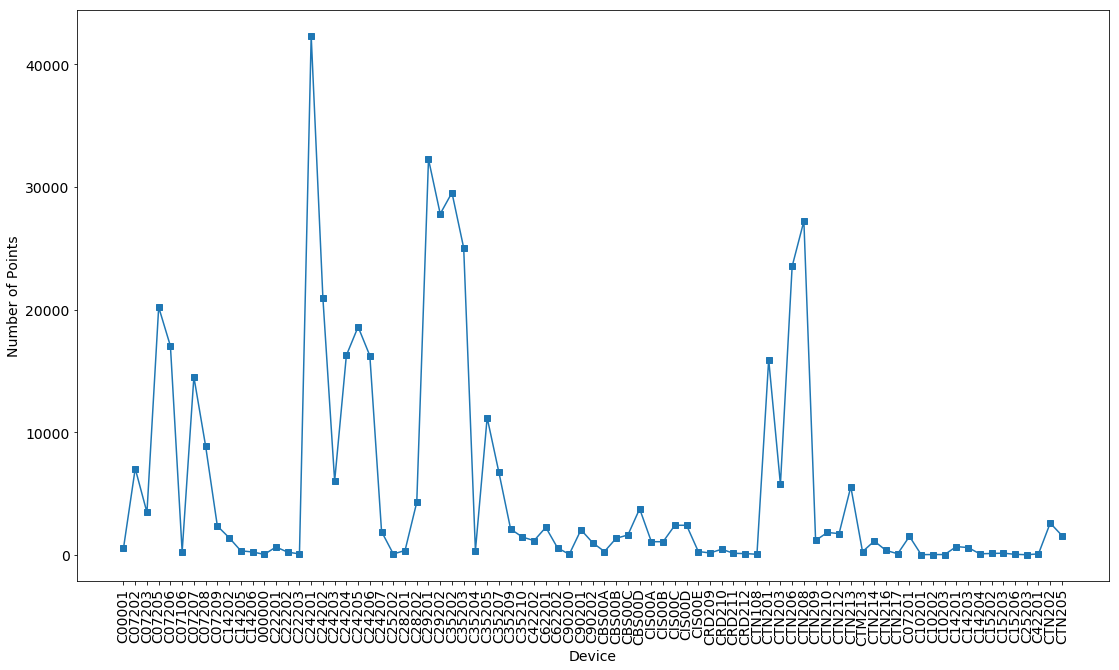

In [57]:
plt.rcParams.update({"font.size":14})
plt.plot(number_device_points,"s-")
plt.xlabel("Device")
plt.ylabel("Number of Points")
plt.xticks(range(len(device_ids)),device_ids,rotation='vertical')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()    

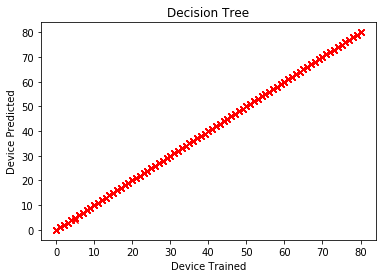

In [42]:
plt.plot(target_list,test_predictions.tolist(),"rx")
plt.xlabel("Device Trained")
plt.ylabel("Device Predicted")
plt.title("Decision Tree")
plt.show()

Testing Noise Mag 1e-08
Testing Noise Mag 0.000526325263158
Testing Noise Mag 0.00105264052632
Testing Noise Mag 0.00157895578947
Testing Noise Mag 0.00210527105263
Testing Noise Mag 0.00263158631579
Testing Noise Mag 0.00315790157895
Testing Noise Mag 0.00368421684211
Testing Noise Mag 0.00421053210526
Testing Noise Mag 0.00473684736842
Testing Noise Mag 0.00526316263158
Testing Noise Mag 0.00578947789474
Testing Noise Mag 0.00631579315789
Testing Noise Mag 0.00684210842105
Testing Noise Mag 0.00736842368421
Testing Noise Mag 0.00789473894737
Testing Noise Mag 0.00842105421053
Testing Noise Mag 0.00894736947368
Testing Noise Mag 0.00947368473684
Testing Noise Mag 0.01


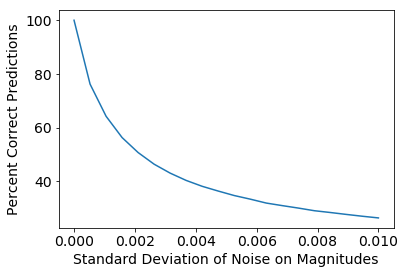

In [63]:
# Now we want %correct as a function of noise
# now a test list with noise
noise_mags=np.linspace(10**-8,10**-2,20)
percent_correct_list=[]
for noise_mag in noise_mags:
    print("Testing Noise Mag {0}".format(noise_mag))
    mag_std=noise_mag
    arg_std=0
    test_list=[]
    test_target_list=[]
    for index,device_id in enumerate(device_ids[:]):
        device=device_history_dictionary[device_id][training_columns].values.tolist()
        for row_index,row in enumerate(device):
            for column_index,column_name in enumerate(training_columns):
                if re.search("mag",column_name) and mag_std!=0:
                    device[row_index][column_index]= row[column_index]+np.random.normal(0,mag_std)
                elif re.search("arg",column_name) and arg_std!=0:
                    device[row_index][column_index]= row[column_index]+np.random.normal(0,arg_std)
                else:
                    pass
        for row_index,row in enumerate(device):
            test_list.append(row)
            test_target_list.append(index)
    test_predictions=two_port_classifier.predict(test_list)
    percent_correct_list.append(percent_correct(target_list,test_predictions))
plt.plot(noise_mags,percent_correct_list)
plt.xlabel("Standard Deviation of Noise on Magnitudes")
plt.ylabel("Percent Correct Predictions")
plt.show()

In [ ]:
# Now train the classifier
classifier_keys=sorted(classifier_dict.keys())[:]
two_port_classifier_list=[]
two_port_prediction_list=[]
for key_index,key in enumerate(classifier_keys):
    print("Begining the training of {0}".format(key))
    two_port_classifier_list.append(classifier_dict[key]())
    try:
        two_port_classifier_list[key_index].fit(training_list, target_list)
        two_port_prediction_list.append(two_port_classifier_list[key_index].predict(training_list))
    except:
        raise
        print("{0} did not work".format(key))
    try:
        plt.close()
        plt.plot(target_list,two_port_prediction_list[key_index].tolist(),"rx")
        plt.xlabel("Device Trained")
        plt.ylabel("Device Predicted")
        plt.title(key)
        plt.show()
    except:pass